## Gradients

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from collections import OrderedDict

from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model


In [2]:
x = np.array([1,3,4,7,13])
y = np.array([5,6,8,11,15])
dx = np.diff(x)
dy = np.diff(y)
dx, dy

(array([2, 1, 3, 6]), array([1, 2, 3, 4]))

### forward diff

In [3]:
dy/dx

array([0.5       , 2.        , 1.        , 0.66666667])

### center diff

Method A from [here](https://www.rug.nl/research/portal/files/3332271/1992JEngMathVeldman.pdf)

$dy/dx = \frac{y_{i+1}-y_{i-1}}{x_{i+1}-x_{i-1}}$

In [4]:
x = np.array([1,3,4,7,13])
y = np.array([0,6,8,11,12])
dx = np.diff(x)
dy = np.diff(y)
dx, dy, len(dx)

(array([2, 1, 3, 6]), array([6, 2, 3, 1]), 4)

In [5]:
fdydx = dy/dx
fdydx

array([3.        , 2.        , 1.        , 0.16666667])

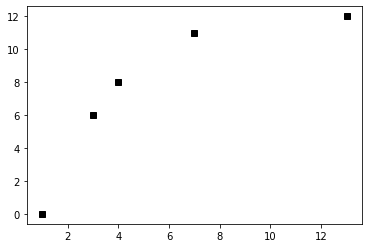

In [6]:
plt.plot(x,y,'s',c='k')

In [7]:
# forward
fdydx = dy/dx
print(fdydx)
fpdpy = np.cumsum(fdydx * dx)
fpdpy = np.concatenate([np.array([0]), fpdpy])
fpdpy

[3.         2.         1.         0.16666667]


array([ 0.,  6.,  8., 11., 12.])

In [8]:
adydx = [fdydx[0]] + list((fdydx[:-1] + fdydx[1:])/2)
print(adydx)
apdpy = np.cumsum(adydx * dx)
apdpy = np.concatenate([np.array([0]), apdpy])
apdpy

[3.0, 2.5, 1.5, 0.5833333333333334]


array([ 0. ,  6. ,  8.5, 13. , 16.5])

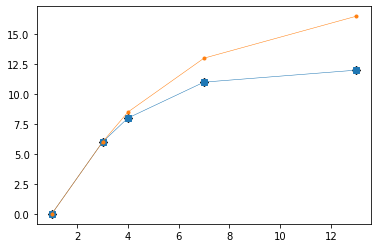

In [9]:
plt.plot(x,y, 'D', c='k')
plt.plot(x, fpdpy, 's-', lw=.5)
plt.plot(x, apdpy, '.-', lw=.5)

In [10]:
# find stride 2 diff so we can get x[i+1] - x[i-1]
dx2 = x[2:] - x[:-2]
dx2

array([3, 4, 9])

In [11]:
dy2 = y[2:] - y[:-2]
dy2

array([8, 5, 4])

In [12]:
dy2/dx2

array([2.66666667, 1.25      , 0.44444444])

In [13]:
# forward diff for i=0
dydx0 = (y[1]-y[0])/(x[1]-x[0])
dydx0

3.0

In [14]:
cdydx = [dydx0] + list(dy2/dx2)
cdydx

[3.0, 2.6666666666666665, 1.25, 0.4444444444444444]

In [15]:
cpdpy = np.cumsum(cdydx * dx)
cpdpy = np.concatenate([np.array([0]), cpdpy])
cpdpy

array([ 0.        ,  6.        ,  8.66666667, 12.41666667, 15.08333333])

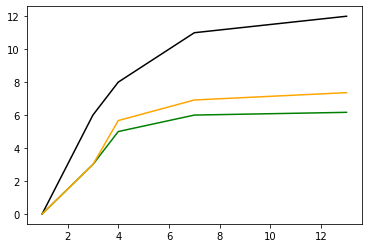

In [16]:
plt.plot(x,y, c='k')
plt.plot(x, np.cumsum([0]+list(fdydx)), c='green')
plt.plot(x, np.cumsum([0]+list(cdydx)), c='orange')

In [17]:
gdydx = np.gradient(y,x,edge_order=1)[:-1]
gdydx

array([3.        , 2.33333333, 1.75      , 0.72222222])

In [18]:
gpdpy = np.cumsum(gdydx * dx)
gpdpy = np.concatenate([np.array([0]), gpdpy])
gpdpy

array([ 0.        ,  6.        ,  8.33333333, 13.58333333, 17.91666667])

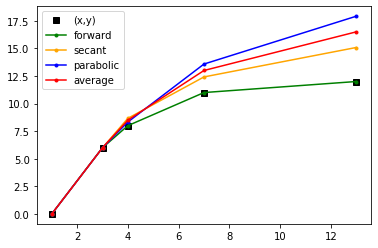

In [19]:
plt.plot(x,y, 's', c='k', label='(x,y)')
plt.plot(x, fpdpy, '.-', c='green', label='forward')
plt.plot(x, cpdpy, '.-', c='orange', label='secant')
plt.plot(x, gpdpy, '.-', c='blue', label='parabolic')
plt.plot(x, apdpy, '.-', c='red', label='average')
plt.legend(loc='upper left')

In [20]:
def finite_differences(x: np.ndarray, y: np.ndarray, which='forward'):
    ignored = 0

    # Group by x, take mean of all y with same x value (they come back sorted too)
    # uniq_x = np.unique(x)
    x = x.round(decimals=10)
    uniq_x = np.unique(x)
    avg_y = np.array([y[x==ux].mean() for ux in uniq_x])

    if len(uniq_x)==1:
        # print(f"ignore {len(x)} in discrete_xc_space")
        ignored += len(x)
        return np.array([[0]],dtype=x.dtype), np.array([0.0]), ignored

    # FORWARD DIFF
    if which=='forward':
        x_deltas = np.diff(uniq_x)
        y_deltas = np.diff(avg_y)
        leaf_slopes = y_deltas / x_deltas  # "rise over run"

    # AVERAGE AROUND CENTER DIFF
    # At position i, take average of forward slope from y[i-1] to y[i] and
    # slope from y[i] to y[i+1].
    # leaf_slopes = [leaf_slopes[0]] + list((leaf_slopes[:-1] + leaf_slopes[1:]) / 2)
    # leaf_slopes = np.array(leaf_slopes)
    # dang, doesn't seem to work

    # CENTER DIFF
    elif which=='secant':
        x_deltas2 = uniq_x[2:] - uniq_x[:-2]  # this is empty if |uniq_x|==2
        y_deltas2 = avg_y[2:] - avg_y[:-2]
        dydx0 = (avg_y[1] - avg_y[0]) / (uniq_x[1] - uniq_x[0]) # forward diff for i=0
        leaf_slopes_ctr = [dydx0] + list(y_deltas2 / x_deltas2)  # "rise over run, stride 2"
        leaf_slopes = np.array(leaf_slopes_ctr)

    elif which=='parabolic':
        leaf_slopes = np.gradient(avg_y, uniq_x)[:-1] # drop last derivative as we won't use it
    # print("ctr",list(leaf_slopes_ctr))
    # print("grd",list(leaf_slopes))

    leaf_xranges = np.array(list(zip(uniq_x, uniq_x[1:])))

    return leaf_xranges, leaf_slopes, ignored

In [21]:
def intg(x, dydx):
    dx = np.diff(x)
    pdpy = np.cumsum(dydx * dx)
    pdpy = np.concatenate([np.array([0]), pdpy])
    return pdpy

In [22]:
def plot_quad(ax,n):
    x = np.array(sorted(np.random.random(size=n)))/10
    y = x**2 + np.sin(100*x)*30
    x2 = np.array(sorted(np.random.random(size=n)+5))
    y2 = x**2 + np.sin(10*x2)*30
    
#     x = np.concatenate([x,x2])
#     y = np.concatenate([y,y2])
#     print(x)
#     print(y)
#     y += np.random.normal(0,5.0) # add noise
    y = y - y[0] # always start from 0
    

    ranges, fdydx, _ = finite_differences(x,y, 'forward')
    ranges, sdydx, _ = finite_differences(x,y, 'secant')
    ranges, pdydx, _ = finite_differences(x,y, 'parabolic')

    ax.scatter(x,y,marker='s',c='k',s=10, label='(x,y)')
    ax.plot(x,intg(x, fdydx), '-', c='blue', lw=.5, label='forward', markersize=3)
    ax.plot(x,intg(x, sdydx), '-', c='orange', lw=.5, label='secant', markersize=3)
    ax.plot(x,intg(x, pdydx), '-', c='red', lw=.5, label='parabolic', markersize=3)
    ax.set_xlabel("x")
    ax.set_title(f"n={n}")

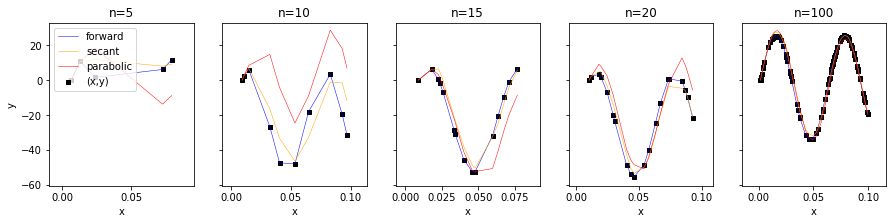

In [23]:
fig, axes = plt.subplots(1,5, figsize=(15,3), sharey=True)
plot_quad(axes[0],5)
axes[0].set_ylabel("y")
axes[0].legend(loc='upper left')
plot_quad(axes[1],10)
plot_quad(axes[2],15)
plot_quad(axes[3],20)
plot_quad(axes[4],100)
plt.savefig("/tmp/foo.pdf")

In [24]:
np.cumsum([1,2])

array([1, 3])